In [324]:
import tensorflow as tf
import pandas as pd
import numpy as np
from os import getcwd, path
import math

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score


from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras import layers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
from tensorflow.python.client import device_lib

from nltk.tokenize import word_tokenize, sent_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn

import matplotlib.pyplot as plt

from collections import defaultdict

import xgboost as xgb

from re import compile
import re

plt.style.use('ggplot')

# Word2Vec 
# import gensim
# model = gensim.models.KeyedVectors.load_word2vec_format('D:/Embeddings/GoogleNews-vectors-negative300.bin.gz', binary=True)

In [325]:
from textaugment import EDA

import nltk
nltk.download(['wordnet','punkt','averaged_perceptron_tagger'])

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

## Parameters

In [326]:
sent_tokenizer = True
use_pretrained_embeddings = True

use_nltk_cleaning = False
text_cleaning = True

use_tfidf_tokenizer = False
use_keras_tokenizer = True

make_all_other_classes_1 = False
remove_class_0 = False
np.random.seed(123)

## Functions

In [327]:
def plot_history(history):
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    
def create_embedding_matrix(filepath, word_index, embedding_dim):
    
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath, encoding="utf8") as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix


def cal_label_accuracy(conf_matrix, verbose = 0):
    
    label_acc = {}
    
    for index, x in enumerate(conf_matrix): 
        
        label_acc[index] = np.round( conf_matrix[index][index]/ sum(conf_matrix[index]) *100 , 2)
        
        if verbose > 0:
        
            print("Accuracy for label", index, ": ", label_acc[index] , " %" )
    
    return label_acc

    
def clean_text(text):
    """Function to clean raw corpus text.

    Parameters
    ----------
    text : obj: numpy.array: `str`
        Corpus text, each element being a sentence

    Returns
    -------
    text: obj: numpy.array : str
        Clean text
    """
    
    REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
    BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
    STOPWORDS = set(stopwords.words('english'))
    
    
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    
    return text

def create_class_weight(labels_dict,mu=1.9):

    # labels_dict : {ind_label: count_label}
    # mu : parameter to tune 

    total = np.sum(list(labels_dict.values()))
    keys = labels_dict.keys()
    class_weight = dict()
    
    for key in keys:
        score = math.log(mu*total/float(labels_dict[key]))
        class_weight[key] = score if score > 1.0 else 1.0
    
    return class_weight


## Data Ingest

## Use 5 Category Data

In [328]:
data_dir = 'data/ML_data_3.0.xlsx'
corpus = pd.read_excel(data_dir ,engine='openpyxl')

corpus = corpus[~corpus['label'].isna()][['text','label']]

In [329]:
corpus

,text,label
0,The stable way of business life many corporate...,0.0
1,"As dozens of companies have already learned, s...",0.0
2,What capabilities will a profitable internatio...,0.0
3,Almost every kind of manufacturer will have to...,0.0
4,Some companies have already responded to the g...,0.0
...,...,...
2125,Growing purchasing volumes are connected to le...,2.0
2126,The Company strategy is to offset price pressu...,2.0
2127,This principle extends beyond the entire supp...,0.0
2128,"As a result, the Company is dependent, in seve...",3.0


In [330]:
# Adjust Class Weights with Linear Functions
class_distribution = np.array(corpus['label'].value_counts() / corpus.shape[0])
y = np.array([0.08,0.23, 0.23, 0.23, .23])

m_s = [-.24, -.2, -.1]  
b_s = [.25, .15, .3]

#linea de regression
m = -0.24 # la relacion es inversa proporcional [-0.1 , -0.5]
b = 0.25 # tras varios experimentos

def class_weights_function(x, m, b):
    return np.round(x*m + b, 3)

class_weight = [class_weights_function(x, m, b) for x in class_distribution]

In [331]:
class_weight

[0.081, 0.229, 0.23, 0.234, 0.235]

In [332]:
# labels_dict
labels_dict = {0: len(corpus[corpus['label']==0]), 1: len(corpus[corpus['label']==1]), 2: len(corpus[corpus['label']==2]), 3: len(corpus[corpus['label']==3]), 4: len(corpus[corpus['label']==4])}

create_class_weight(labels_dict)

{0: 1.0,
 1: 3.4229292222894947,
 2: 3.3569712544976973,
 3: 3.1466758456613366,
 4: 3.085375319797541}

In [333]:
 # Filter all NAs values
corpus.dropna(inplace= True)

 # Make Sure labels are integers
corpus['label'] = corpus['label'].astype(int)


# Text Augmentation

## Use 2 Category Data

In [334]:
# current_path = getcwd()

# filepath_dict = {'yelp':   'data/yelp_labelled.txt',
#                  'amazon': 'data/amazon_cells_labelled.txt',
#                  'imdb':   'data/imdb_labelled.txt'}

# df_list = []

# for source, filepath in filepath_dict.items():
    
#     df = pd.read_csv(path.join(current_path, filepath), names=['sentence', 'label'], sep='\t')
#     df['source'] = source  # Add another column filled with the source name
#     df_list.append(df)

# df = pd.concat(df_list)
# df.rename(columns = {'sentence':'text'}, inplace = True)
# corpus = df

In [335]:
corpus.head()

,text,label
0,The stable way of business life many corporate...,0
1,"As dozens of companies have already learned, s...",0
2,What capabilities will a profitable internatio...,0
3,Almost every kind of manufacturer will have to...,0
4,Some companies have already responded to the g...,0


In [336]:
corpus.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2130 entries, 0 to 2129
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    2130 non-null   object
 1   label   2130 non-null   int32 
dtypes: int32(1), object(1)
memory usage: 41.6+ KB


## 0. Text Cleaning

In [337]:
if text_cleaning:

    corpus = corpus.reset_index(drop=True)

    REPLACE_BY_SPACE_RE = compile('[/(){}\[\]\|@,;]')
    BAD_SYMBOLS_RE = compile('[^0-9a-z #+_]')
    STOPWORDS = set(stopwords.words('english'))
  
    corpus['text'] = corpus['text'].apply(clean_text)
    corpus['text'] = corpus['text'].str.replace('\d+', '')

In [338]:
# Create Filter on the data to avoid the imbalance classes problem
# if make_all_other_classes_1:

#     corpus['label_original'] = corpus.loc[:,'label']
#     corpus['label'] = np.where( corpus['label'] > 0 , 1, corpus['label'])

# elif remove_class_0:

#     corpus['label_original'] = corpus.loc[:,'label']
#     corpus = corpus[~corpus['label'].isin([0])]
#     corpus['label'] = corpus['label'].map({1:0,2:1,3:2,4:3})

In [339]:
corpus.head()

,text,label
0,stable way business life many corporate purcha...,0
1,dozens companies already learned supply demand...,0
2,capabilities profitable international business...,0
3,almost every kind manufacturer answer questions,0
4,companies already responded growing pressures,0


## 1. NLTK - Data preprocessing

- I. Remove Blank rows in Data, if any
- II. Change all the text to lower case
- III. Word Tokenization
- IV. Remove Stop words
- V. Remove Non-alpha text
- VI. Word Lemmatization

In [340]:
if use_nltk_cleaning:

    # Step III : Tokenization : In this each entry in the corpus will be broken into set of words
    if sent_tokenizer: 
        corpus['text'] = [sent_tokenize(x) for x in corpus['text']] 
    else:
        #Corpus['text'] = Corpus['text'].apply(lambda x: str(word_tokenize(x)) )
        corpus['text'] = [word_tokenize(x) for x in corpus['text']]

    # Step IV, V, VI : Remove Stop words, Non-Numeric and perfom Word Stemming/Lemmenting.
    # WordNetLemmatizer requires Pos tags to understand if the word is noun or verb or adjective etc. By default it is set to Noun
    # Word Classification for Lemmatizer https://www.nltk.org/_modules/nltk/corpus/reader/wordnet.html
    # https://www.geeksforgeeks.org/defaultdict-in-python/
    tag_map = defaultdict(lambda: wn.NOUN)
    tag_map['J'] = wn.ADJ
    tag_map['V'] = wn.VERB
    tag_map['R'] = wn.ADV

    # Execute Word Tagging
    for index, entry in enumerate(corpus['text']):

        # Declaring Empty List to store the words that follow the rules for this step
        lemma_words = []

        # Initializing WordNetLemmatizer()
        word_Lemmatized = WordNetLemmatizer()

        # pos_tag function below will provide the 'tag' i.e if the word is Noun(N) or Verb(V) or something else.
        # Posttagging reference : https://www.nltk.org/book/ch05.html 

        for word, tag in pos_tag(entry):

            # Below condition is to check for Stop words and consider only alphabets
            # List of stop words https://gist.github.com/sebleier/554280, https://www.nltk.org/book/ch02.html

            # NLTK check for an alphabetic word https://tedboy.github.io/nlps/generated/generated/nltk.text_type.isalpha.html
            if word not in stopwords.words('english') and word.isalpha():

                # Reference https://www.geeksforgeeks.org/python-lemmatization-with-nltk/
                # Use first letter of NLTK Postagging as "pos" parameter mapping it through the dict tag_map
                lemma_word = word_Lemmatized.lemmatize(word = word,
                                                       pos = tag_map[tag[0]]  )
                # Append word back to the empty list
                lemma_words.append(lemma_word)

        # The final processed set of words for each iteration will be stored in 'text_final'
        corpus.loc[index,'text_clean'] = ' '.join(lemma_words)
    
    corpus.loc[:,'text'] = corpus['text_clean']

# 2. Text Augmentation

In [341]:
def get_only_chars(line):

    clean_line = ""

    line = line.lower()
    line = line.replace(" 's", " is") 
    line = line.replace("-", " ") #replace hyphens with spaces
    line = line.replace("\t", " ")
    line = line.replace("\n", " ")
    line = line.replace("'", "")

    for char in line:
        if char in 'qwertyuiopasdfghjklzxcvbnm ':
            clean_line += char
        else:
            clean_line += ' '

    clean_line = re.sub(' +',' ',clean_line) #delete extra spaces
    #print(clean_line)
    if clean_line[0] == ' ':
        clean_line = clean_line[1:]
    return clean_line

In [342]:
def text_augmentation_synonym(sentence, alpha_sr=0.1, num_aug=10):
    """
    Generate Synonyms sentences for a given sentence

    alpha: percentage of words to be synonymized in a sentence

    """

    sentence = get_only_chars(sentence)  # ["This is a house "]
    words = sentence.split(' ') # ["This",  "is", "a", "house", ""]
    words = [word for word in words if word is not '']
    num_words = len(words)

    augmented_sentences = []
    num_new_per_technique = int(num_aug/4)+1

    if (alpha_sr > 0):

        n_sr = max(1, int(alpha_sr*num_words))

        for random_state in range(num_aug):

            t = EDA(random_state = random_state)

            a_words = t.synonym_replacement(sentence, n_sr)

            a_words = ''.join(a_words)

            # only append if not already available
            if not a_words in augmented_sentences:

                augmented_sentences.append(a_words)


    return augmented_sentences

In [343]:
def create_corpus_augmented(corpus, alpha_sr, num_aug, verbose = 0 ):
    """
    This function takes every sentence in the corpus and generates
    synonym sentece give by the parameter num_aug. The number of words
    in each sentence to be synonymized is controlled by the parameter
    alpha_sr ( 0.0 - 1.0) where 1.0 means change all the words. 

    """
    corpus_augmented = []

    for index, row in corpus.iterrows():
        
        if verbose > 1:
            print("Generating synomyms for sentence :" , row['text'] )

        new_senteces = text_augmentation_synonym(sentence = row['text'],
                            alpha_sr = alpha_sr, 
                            num_aug = num_aug) 

        new_corpus_augmented = pd.DataFrame(dict( text = new_senteces ) )

        # Add Label
        new_corpus_augmented['label'] = row['label']  

        corpus_augmented.append(new_corpus_augmented)

    return pd.concat(corpus_augmented).reset_index(drop = True)

In [344]:
# Augment Corpus 
augmented_corpus = create_corpus_augmented(corpus = corpus, alpha_sr = 0.05, num_aug = 2)

In [345]:
# Add new senteces to original corpus
corpus = pd.concat([corpus, augmented_corpus]).reset_index(drop = True)

In [346]:
corpus.head()

,text,label
0,stable way business life many corporate purcha...,0
1,dozens companies already learned supply demand...,0
2,capabilities profitable international business...,0
3,almost every kind manufacturer answer questions,0
4,companies already responded growing pressures,0


# 3. Prepare Trainig and Test data

In [347]:
# Get training X data
sentences = corpus['text'].values

# Use Label encoder for the expected output
Encoder = LabelEncoder()
encoded_Y = Encoder.fit_transform(corpus['label'].values)
Y = pd.get_dummies(encoded_Y).values

sentences_train, sentences_test, Y_train, Y_test = train_test_split( sentences, Y, test_size=0.25, stratify = corpus['label'])


In [348]:
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (6318, 5)


In [349]:
encoded_Y

array([0, 0, 0, ..., 3, 4, 4], dtype=int64)

## 3. Word Tokenizer 

In [350]:
# Hyperparameters
sent_tokenizer = True
use_nltk_cleaning = False
use_tfidf_tokenizer = False # TODO: Adjust for input to CNN
use_keras_tokenizer = True
use_pretrained_embeddings = False
use_tfidf_as_embedding_weights = False

# Initialize Model
epochs = 30
batch_size = 16
output_label = len(np.unique(encoded_Y))

# Append "0" add the sentences ending to have equal sentences length
seq_input_len = 50
num_word = 5000

In [351]:
if use_keras_tokenizer:
    
    # Start Tokenizer Object
    tokenizer = Tokenizer(num_words=num_word,lower=None)

    # Train vocabulary
    tokenizer.fit_on_texts(sentences_train)

    X_train = tokenizer.texts_to_sequences(sentences_train) 
        
    X_test = tokenizer.texts_to_sequences(sentences_test)

    # XGBoost ------------
    X = tokenizer.texts_to_sequences(sentences)
    #---------------------

    vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index
   
    vocab = tokenizer.word_index

    X_train_keras = pad_sequences(X_train, padding='post', maxlen=seq_input_len)
    X_test_keras = pad_sequences(X_test, padding='post', maxlen=seq_input_len)

    # XGBoost ------------
    #X_keras = pad_sequences(X, padding='post', maxlen=seq_input_len)
    #---------------------

use_tfidf_tokenizer = False
if use_tfidf_tokenizer:
    
    # Create new Class TfidfVectorizer with max 5000 features
    Tfidf_vect = TfidfVectorizer(max_features=5000)

    # Learn vocabulary and idf from training set
    Tfidf_vect.fit(sentences_train)

    # Transfor both the train and the test to document-term matrix
    X_train_Tfidf = Tfidf_vect.transform(sentences_train).toarray()
    X_test_Tfidf = Tfidf_vect.transform(sentences_test).toarray()

    #XGBoost -------
    #X_Tfidf = Tfidf_vect.transform(sentences)
    #----------
    
    vocab = Tfidf_vect.vocabulary_
    
    vocab_size = len(vocab) + 1

    

## 4. Use pre-trained Embedding Space ( GloVe )

In [352]:
if use_pretrained_embeddings: 
    
    embedding_dim = 300
    
    embedding_matrix = create_embedding_matrix(
     filepath = 'D:/Embeddings/GloVe/glove.6B.300d.txt',
     word_index = vocab, 
     embedding_dim = embedding_dim)

In [355]:
embedding_matrix.shape

(6554, 300)

In [354]:
len(vocab)

5105

# 4. CNN With Keras

In [256]:
del model

In [356]:
use_pretrained_embeddings

False

In [257]:
model = Sequential()

if use_pretrained_embeddings:  

    # Use Glove Embedding Matrix
    
    model.add(layers.Embedding(embedding_matrix.shape[0], embedding_dim,  # Word Vector Dimension
                                weights=[embedding_matrix], 
                                input_length=seq_input_len, 
                                trainable=False))
else: 
    
    # Keras Embedding Matrix Generation
    
    embedding_dim = 300
    model.add(layers.Embedding(vocab_size, # Vocabulary Size
                                embedding_dim, # Word Vector Dimension
                                input_length = seq_input_len))

# Filters: No. of output filter in the convolution
# kernel_size: An integer or tuple/list of a single integer, specifying the length of the 1D convolution window.
model.add(layers.Conv1D(filters = 256, kernel_size = 2, activation='relu'))

# Filters: No. of output filter in the convolution
# kernel_size: An integer or tuple/list of a single integer, specifying the length of the 1D convolution window.
model.add(layers.Conv1D(filters = 64, kernel_size = 3, activation='relu'))

# Global max pooling operation for 1D temporal data.
# Downsamples the input representation by taking the maximum value over the time dimension
model.add(layers.GlobalMaxPooling1D())

model.add(layers.Dense(16, activation='relu'))

model.add(layers.Dense(output_label, activation='sigmoid'))

model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 50, 300)           1529100   
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 49, 256)           153856    
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 47, 64)            49216     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                1040      
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 85        
Total params: 1,733,297
Trainable params: 1,733,297
Non-trainable params: 0
____________________________________________

Restoring model weights from the end of the best epoch.
Epoch 00009: early stopping
Training Accuracy: 0.9985
Testing Accuracy:  0.9797


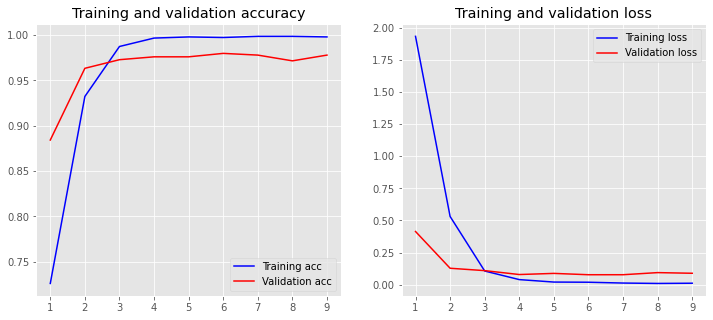

In [260]:
#class_weight = {0: 0.08,
                #1: 0.23,
                #2: 0.23,
                #3: 0.23,
                #4: 0.23}

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=1, mode='auto', baseline=None, restore_best_weights=True)

history = model.fit(X_train_keras, Y_train,
                    epochs = epochs,
                    verbose = False,
                    validation_data = (X_test_keras, Y_test),
                    class_weight = create_class_weight(labels_dict),
                    batch_size = batch_size, 
                    callbacks = callback)

loss, accuracy = model.evaluate(X_train_keras, Y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test_keras, Y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)
 

In [263]:
create_class_weight(labels_dict)

{0: 1.0,
 1: 3.4229292222894947,
 2: 3.3569712544976973,
 3: 3.1466758456613366,
 4: 3.085375319797541}

In [269]:
loss

0.07834558933973312

In [264]:
accuracy

0.9797468185424805

In [265]:
Y_pred = model.predict(X_test_keras)

for pred in Y_pred:
    for index, value in enumerate(pred):
        if value == max(pred):
            pred[index] = int(1)
        else: 
            pred[index] = int(0)

conf_matrix = confusion_matrix(Y_test.argmax(axis=1), Y_pred.argmax(axis=1)) / len(Y_pred)
cal_label_accuracy(conf_matrix, verbose = 1)

Accuracy for label 0 :  98.69  %
Accuracy for label 1 :  92.94  %
Accuracy for label 2 :  100.0  %
Accuracy for label 3 :  95.16  %
Accuracy for label 4 :  96.24  %


{0: 98.69, 1: 92.94, 2: 100.0, 3: 95.16, 4: 96.24}

In [268]:
mse_value, mae_value = model.evaluate(X_test_keras, Y_pred, verbose=0)

print(mse_value)

0.018793469294905663


In [20]:
from os.path import join

from sys import path
path.append( join( join( getcwd() , 'functions/' ) ) )

from functions import preprocessing, modelling, postprocessing
from config import ConfigDict

import openpyxl
from sklearn import feature_selection

# temp
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer

In [47]:
import datetime
timestamp = datetime.datetime.today().strftime("%Y-%m-%d-%H-%M-%S")


In [48]:
from keras.models import load_model


In [49]:
output_vectorizer = "results/vectorizer"
file_name = "keras_vectorizer_012345"

postprocessing.store_to_pickle(tokenizer, output_vectorizer, timestamp, file_name )

output_model = os.path.join("results/model",f"{timestamp}_CNN_weighted_classes.h5")
model.save(output_model)
loaded_model = load_model(output_model)

## Load Models 

In [78]:
sentences = pd.DataFrame( dict(text = pd.read_excel( "C:/Repositories/Results.xlsx",  engine='openpyxl')['text']))


In [93]:
if text_cleaning:

    sentences = sentences.reset_index(drop=True)
    
    sentences['text'] = sentences['text'].apply(lambda x: re.sub( r'[+-]?([0-9]*[.])?[0-9]+', '', str(x)))
    sentences['text'] = sentences['text'].apply(clean_text)
    

In [95]:
if use_nltk_cleaning:

    # Step III : Tokenization : In this each entry in the corpus will be broken into set of words
    if sent_tokenizer: 
        sentences['text'] = [sent_tokenize(x) for x in sentences['text']] 
    else:
        #Corpus['text'] = Corpus['text'].apply(lambda x: str(word_tokenize(x)) )
        sentences['text'] = [word_tokenize(x) for x in sentences['text']]

    # Step IV, V, VI : Remove Stop words, Non-Numeric and perfom Word Stemming/Lemmenting.
    # WordNetLemmatizer requires Pos tags to understand if the word is noun or verb or adjective etc. By default it is set to Noun
    # Word Classification for Lemmatizer https://www.nltk.org/_modules/nltk/corpus/reader/wordnet.html
    # https://www.geeksforgeeks.org/defaultdict-in-python/
    tag_map = defaultdict(lambda: wn.NOUN)
    tag_map['J'] = wn.ADJ
    tag_map['V'] = wn.VERB
    tag_map['R'] = wn.ADV

    # Execute Word Tagging
    for index, entry in enumerate(sentences['text']):

        # Declaring Empty List to store the words that follow the rules for this step
        lemma_words = []

        # Initializing WordNetLemmatizer()
        word_Lemmatized = WordNetLemmatizer()

        # pos_tag function below will provide the 'tag' i.e if the word is Noun(N) or Verb(V) or something else.
        # Posttagging reference : https://www.nltk.org/book/ch05.html 

        for word, tag in pos_tag(entry):

            # Below condition is to check for Stop words and consider only alphabets
            # List of stop words https://gist.github.com/sebleier/554280, https://www.nltk.org/book/ch02.html

            # NLTK check for an alphabetic word https://tedboy.github.io/nlps/generated/generated/nltk.text_type.isalpha.html
            if word not in stopwords.words('english') and word.isalpha():

                # Reference https://www.geeksforgeeks.org/python-lemmatization-with-nltk/
                # Use first letter of NLTK Postagging as "pos" parameter mapping it through the dict tag_map
                lemma_word = word_Lemmatized.lemmatize(word = word,
                                                       pos = tag_map[tag[0]]  )
                # Append word back to the empty list
                lemma_words.append(lemma_word)

        # The final processed set of words for each iteration will be stored in 'text_final'
        sentences.loc[index,'text_clean'] = ' '.join(lemma_words)
    
    sentences.loc[:,'text'] = sentences['text_clean']

In [125]:
loaded_keras_tokenizer = postprocessing.load_pickle(output_path = output_vectorizer , 
                                    timestamp = timestamp , 
                                    file_name = file_name)

CNN_model =  loaded_model = load_model(output_model)

new_sentence_train = loaded_keras_tokenizer.texts_to_sequences(sentences['text']) 

new_sentence_train = pad_sequences(new_sentence_train, padding='post', maxlen=seq_input_len)

In [127]:
Y_pred = CNN_model.predict(new_sentence_train)
Y_label = []

for pred in Y_pred:
    for index, value in enumerate(pred):
        if value == max(pred):
            Y_label.append(index)
            pred[index] = int(1)
        else: 
            pred[index] = int(0)

In [129]:
sentences['label'] = Y_label

In [130]:
sentences.head()

,text,text_clean,label
0,procure raw material variety supplier around w...,procure raw material variety supplier around w...,1
1,generally seek obtain material region product ...,generally seek obtain material region product ...,1
2,significant raw material use manufacture produ...,significant raw material use manufacture produ...,1
3,december eperiencedany significant shortage ra...,december eperiencedany significant shortage ra...,1
4,commodity cost volatility notably relate coppe...,commodity cost volatility notably relate coppe...,0


In [131]:
sentences['label'].unique()

array([1, 0, 4, 2, 3], dtype=int64)

In [132]:
sentences[['text','label']].to_excel(r'C:/Repositories/Classifications_5300.xlsx', index = False)

In [30]:
y = Y_train
X_names = loaded_keras_tokenizer.get_feature_names()
p_value_limit = 0.95
dtf_features = pd.DataFrame()

for cat in np.unique(y):
    chi2, p = feature_selection.chi2(X_train, y==cat)
    dtf_features = dtf_features.append(pd.DataFrame(
                   {"feature":X_names, "score":1-p, "y":cat}))
    dtf_features = dtf_features.sort_values(["y","score"], 
                    ascending=[True,False])
    dtf_features = dtf_features[dtf_features["score"]>p_value_limit]
X_names = dtf_features["feature"].unique().tolist()

for cat in np.unique(y):
   print("# {}:".format(cat))
   print("  . selected features:",
         len(dtf_features[dtf_features["y"]==cat]))
   print("  . top features:", ",".join(
dtf_features[dtf_features["y"]==cat]["feature"].values[:30]))
   print(" ")

AttributeError: 'Tokenizer' object has no attribute 'get_feature_names'

## 4.1 CNN with TFIDF

In [59]:
# Principal Component Analysis - Para reducir dimensionalidad 

In [68]:
embedding_dim

300

In [69]:
vocab_size

3487

In [70]:
model = Sequential()

model.add(layers.Embedding(vocab_size, embedding_dim, input_length=X_train_Tfidf.shape[1]))

# Filters: No. of output filter in the convolution
# kernel_size: An integer or tuple/list of a single integer, specifying the length of the 1D convolution window.
model.add(layers.Conv1D(filters = 256, kernel_size = 2, activation='relu'))

# Global max pooling operation for 1D temporal data.
# Downsamples the input representation by taking the maximum value over the time dimension
#model.add(layers.GlobalMaxPooling1D())
model.add(layers.Conv1D(filters = 32, kernel_size = 3, activation='relu'))

model.add(layers.GlobalMaxPooling1D())

model.add(layers.Dense(10, activation='relu'))

model.add(layers.Dense(output_label, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 3486, 300)         1046100   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 3485, 128)         76928     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 3483, 32)          12320     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                330       
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 22        
Total params: 1,135,700
Trainable params: 1,135,700
Non-trainable params: 0
____________________________________________

Wall time: 0 ns
Training Accuracy: 0.7281
Testing Accuracy:  0.7430


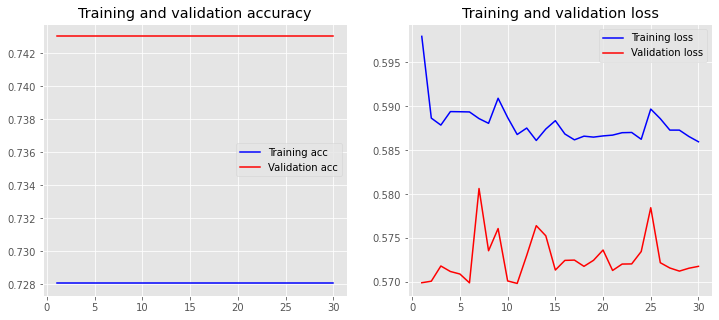

In [71]:
%time

history = model.fit(X_train_Tfidf, Y_train,
                    epochs = epochs,
                    verbose = False,
                    validation_data = (X_test_Tfidf, Y_test),
                    batch_size = batch_size)

loss, accuracy = model.evaluate(X_train_Tfidf, Y_train, verbose=False)
print("Training Accuracy: {:.4f}".      format(accuracy))
loss, accuracy = model.evaluate(X_test_Tfidf, Y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

## 7. Run Model - Recurrent Neural Networks - RNN

Reference: https://towardsdatascience.com/multi-class-text-classification-with-lstm-1590bee1bd17

In [212]:
del model

In [213]:
model = Sequential()

if use_pretrained_embeddings:  
  
    model.add(layers.Embedding(vocab_size, embedding_dim, 
                               weights = [embedding_matrix], 
                               input_length = seq_input_len, 
                               trainable = False))
else: 
    embedding_dim = 100 # Output Dimension - seq output length
    model.add(layers.Embedding(vocab_size, embedding_dim, input_length = seq_input_len))
    
model.add(layers.SpatialDropout1D(0.2))
model.add(layers.LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(50, activation='softmax'))
model.add(layers.Dense(output_label, activation='sigmoid'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [218]:
epochs

10

Epoch 1/10
6/6 [==============================] - 3s 488ms/step - loss: 0.2653 - accuracy: 0.7642 - val_loss: 0.5653 - val_accuracy: 0.7483
Epoch 2/10
6/6 [==============================] - 3s 476ms/step - loss: 0.2680 - accuracy: 0.7583 - val_loss: 0.5647 - val_accuracy: 0.7483
Epoch 3/10
6/6 [==============================] - 3s 462ms/step - loss: 0.2690 - accuracy: 0.7591 - val_loss: 0.5648 - val_accuracy: 0.7483
Epoch 4/10
6/6 [==============================] - 3s 470ms/step - loss: 0.2665 - accuracy: 0.7583 - val_loss: 0.5653 - val_accuracy: 0.7483
Epoch 5/10
6/6 [==============================] - 3s 458ms/step - loss: 0.2641 - accuracy: 0.7731 - val_loss: 0.5661 - val_accuracy: 0.7483
Training Accuracy: 0.7713
Testing Accuracy:  0.7908


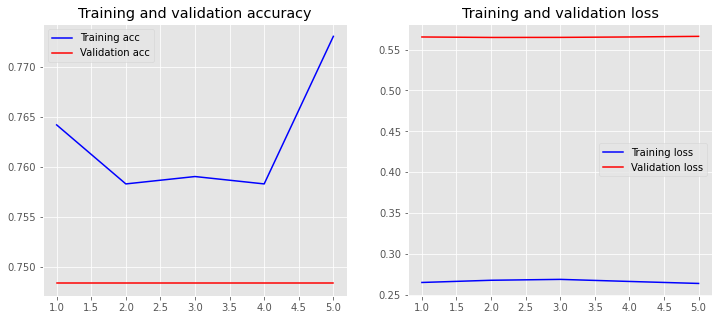

In [242]:
# train_x = np.asarray(X_train_keras)
# train_y = np.asarray(Y_train)
# validation_x = np.asarray(X_test_keras)
# validation_y = np.asarray(Y_test)
class_weight = {0: 0.25,
                1: 0.75}z


history = model.fit(X_train_keras, 
                    Y_train, 
                    epochs = 10, 
                    batch_size = batch_size,
                    validation_data = (X_test_keras, Y_test), 
                    validation_split=0.1,
                    verbose = True,
                    class_weight= class_weight,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])


loss, accuracy = model.evaluate(X_train_keras, Y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test_keras, Y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

In [243]:
Y_pred = model.predict(X_test_keras)

In [244]:
for pred in Y_pred:
    for index, value in enumerate(pred):
        if value == max(pred):
            pred[index] = int(1)
        else: 
            pred[index] = int(0)

In [245]:
conf_matrix = confusion_matrix(Y_test.argmax(axis=1), Y_pred.argmax(axis=1)) / len(Y_pred)
cal_label_accuracy(conf_matrix, verbose = 1)

Accuracy for label 0 :  93.16  %
Accuracy for label 1 :  35.25  %


{0: 93.16, 1: 35.25}

# 8. BILSTM

In [371]:
del model

In [372]:
model = Sequential()

model.add(layers.Embedding(embedding_matrix.shape[0], embedding_dim, 
                            weights = [embedding_matrix], 
                            input_length = seq_input_len, 
                            trainable = False))

model.add(layers.Bidirectional(layers.LSTM(64,  return_sequences=True)))

model.add(layers.Bidirectional(layers.LSTM(32)))

model.add(layers.Dense(64, activation='relu'))

model.add(layers.Dropout(0.5))

model.add(layers.Dense(output_label, activation="sigmoid"))

In [373]:
model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 50, 300)           1966200   
_________________________________________________________________
bidirectional_6 (Bidirection (None, 50, 128)           186880    
_________________________________________________________________
bidirectional_7 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_12 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 5)                 325       
Total params: 2,198,781
Trainable params: 232,581
Non-trainable params: 1,966,200
_____________________________________

In [ ]:
model.fit(X_train_keras, Y_train,
                    epochs = epochs,
                    verbose = False,
                    validation_data = (X_test_keras, Y_test),
                    class_weight = create_class_weight(labels_dict),
                    batch_size = batch_size, 
                    callbacks = callback)

Training Accuracy: 0.9833
Testing Accuracy:  0.9259


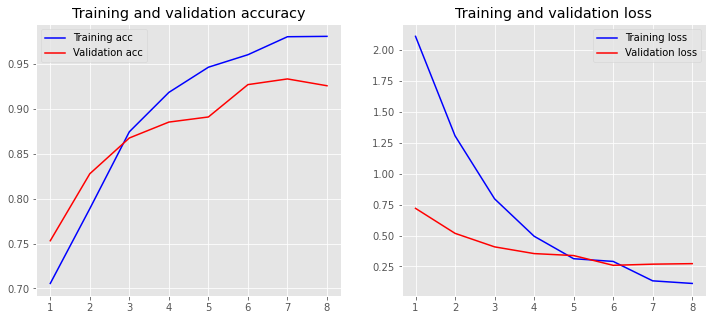

In [375]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=1, mode='auto', baseline=None, restore_best_weights=True)

history = model.fit(X_train_keras, Y_train,
                    epochs = 15,
                    verbose = False,
                    validation_data = (X_test_keras, Y_test),
                    batch_size = batch_size, 
                    class_weight = create_class_weight(labels_dict),
                    )

loss, accuracy = model.evaluate(X_train_keras, Y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test_keras, Y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)
 

In [376]:
Y_pred = model.predict(X_test_keras)

for pred in Y_pred:
    for index, value in enumerate(pred):
        if value == max(pred):
            pred[index] = int(1)
        else: 
            pred[index] = int(0)

In [377]:
conf_matrix = confusion_matrix(Y_test.argmax(axis=1), Y_pred.argmax(axis=1)) / len(Y_pred)
cal_label_accuracy(conf_matrix, verbose = 1)

Accuracy for label 0 :  95.77  %
Accuracy for label 1 :  76.53  %
Accuracy for label 2 :  77.88  %
Accuracy for label 3 :  86.05  %
Accuracy for label 4 :  95.62  %


{0: 95.77, 1: 76.53, 2: 77.88, 3: 86.05, 4: 95.62}

## 8. GRU NN

In [246]:
emb_dim = embedding_matrix.shape[1]
gru_model = Sequential()


if use_pretrained_embeddings:  
  
    gru_model.add(layers.Embedding(vocab_size, embedding_dim, 
                               weights = [embedding_matrix], 
                               input_length = seq_input_len, 
                               trainable = False))
else: 
    embedding_dim = 100 # Output Dimension - seq output length
    gru_model.add(layers.Embedding(vocab_size, embedding_dim, input_length = seq_input_len))
    
gru_model.add(layers.GRU(32, return_sequences=False))
gru_model.add(layers.Dropout(0.5))
#gru_model.add(layers.Dense(10, activation='softmax'))
gru_model.add(layers.Dense(output_label, activation = 'sigmoid'))
gru_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(gru_model.summary())

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_31 (Embedding)     (None, 50, 300)           1051800   
_________________________________________________________________
gru_9 (GRU)                  (None, 32)                32064     
_________________________________________________________________
dropout_12 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_44 (Dense)             (None, 2)                 66        
Total params: 1,083,930
Trainable params: 32,130
Non-trainable params: 1,051,800
_________________________________________________________________
None


In [247]:
train_x = np.asarray(X_train_keras)
train_y = np.asarray(Y_train)
validation_x = np.asarray(X_test_keras)
validation_y = np.asarray(Y_test)

In [248]:
class_weight = {0: 0.25,
                1: 0.75}

history = gru_model.fit(train_x, 
                    train_y, 
                    epochs = epochs, 
                    batch_size = batch_size,
                    validation_data = (validation_x, validation_y), 
                    class_weight = class_weight)

Epoch 1/10
6/6 [==============================] - 4s 226ms/step - loss: 0.2716 - accuracy: 0.4068 - val_loss: 0.7003 - val_accuracy: 0.2430
Epoch 2/10
6/6 [==============================] - 1s 111ms/step - loss: 0.2688 - accuracy: 0.2766 - val_loss: 0.7056 - val_accuracy: 0.2430
Epoch 3/10
6/6 [==============================] - 1s 108ms/step - loss: 0.2707 - accuracy: 0.2832 - val_loss: 0.7115 - val_accuracy: 0.2430
Epoch 4/10
6/6 [==============================] - 1s 105ms/step - loss: 0.2691 - accuracy: 0.2786 - val_loss: 0.7177 - val_accuracy: 0.2430
Epoch 5/10
6/6 [==============================] - 1s 112ms/step - loss: 0.2679 - accuracy: 0.2755 - val_loss: 0.7229 - val_accuracy: 0.2430
Epoch 6/10
6/6 [==============================] - 1s 113ms/step - loss: 0.2676 - accuracy: 0.2740 - val_loss: 0.7270 - val_accuracy: 0.2430
Epoch 7/10
6/6 [==============================] - 1s 113ms/step - loss: 0.2738 - accuracy: 0.2956 - val_loss: 0.7313 - val_accuracy: 0.2430
Epoch 8/10
6/6 [====

In [249]:

train_gru_results = gru_model.evaluate(train_x, train_y, verbose=0, batch_size=256)
test_gru_results = gru_model.evaluate(validation_x, validation_y, verbose=0, batch_size=256)
print(f'Train accuracy: {train_gru_results[1]*100:0.2f}')
print(f'Test accuracy: {test_gru_results[1]*100:0.2f}')

Train accuracy: 27.66
Test accuracy: 24.30


In [250]:
Y_pred = gru_model.predict(X_test_keras)

for pred in Y_pred:
    for index, value in enumerate(pred):
        if value == max(pred):
            pred[index] = int(1)
        else: 
            pred[index] = int(0)

conf_matrix = confusion_matrix(Y_test.argmax(axis=1), Y_pred.argmax(axis=1)) / len(Y_pred)
cal_label_accuracy(conf_matrix, verbose = 1)

Accuracy for label 0 :  0.0  %
Accuracy for label 1 :  100.0  %


{0: 0.0, 1: 100.0}

## 8. XGBoost


In [21]:
pl_xgb_tf_idf = Pipeline(steps=[('xgboost', xgb.XGBClassifier(objective='multi:softmax',num_class=2))])
#scores = cross_val_score(pl_xgb_tf_idf, X_Tfidf, encoded_Y, cv=5)
#print('Accuracy for Tf-Idf & XGBoost Classifier : ', scores.mean())


In [23]:
from sklearn.model_selection import GridSearchCV

In [24]:
param_grid = dict(xgboost__n_estimators=[100,200,300])
grid_search = GridSearchCV(pl_xgb_tf_idf, param_grid=param_grid,cv=5)

In [25]:
grid_result = grid_search.fit(X_train_Tfidf, Y_train_encoded)

[17:40:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:40:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:40:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:40:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

In [69]:
#grid_search.predict(X_Tfidf[0:1])

array([1], dtype=int64)

In [26]:
test_accuracy = grid_search.score(X_test_Tfidf, Y_test_encoded)

In [28]:
Y_pred = grid_search.predict(X_test_Tfidf)

# Generate Confusion Matrix
conf_matrix = confusion_matrix(Y_pred, Y_test_encoded) / len(Y_pred)

# Calculate Label Accuracy
label_acc = cal_label_accuracy(conf_matrix, verbose  = 1)

Accuracy for label 0 :  76.92  %
Accuracy for label 1 :  43.59  %
Accuracy for label 2 :  61.54  %
Accuracy for label 3 :  83.87  %


In [29]:
print('Accuracy for Tf-Idf & XGBoost Classifier : ',test_accuracy)

Accuracy for Tf-Idf & XGBoost Classifier :  0.6444444444444445
